### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- just use async langchain, support google vs openai vs anthropic transparently
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (newscatcher_sources, fn_initialize, fn_download_sources, fn_extract_urls,
                                 fn_verify_download, fn_extract_newscatcher, fn_filter_urls, fn_topic_clusters,
                                 fn_topic_analysis, fn_download_pages, fn_summarize_pages, fn_propose_cats,
                                 fn_compose_summary, fn_rewrite_summary, fn_is_revision_complete, fn_send_mail
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
LangChain         0.3.18
OpenAI            1.63.1
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Test LLM calling

In [4]:
# a basic LLM call with langchain\
openai_model = ChatOpenAI(model="gpt-4o-mini")

response = openai_model.invoke([
    SystemMessage(content="You are a translator. Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])

response

2025-02-17 10:51:25,463 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 39, 'total_tokens': 56, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-4e2f49cc-4e3c-4d6a-951f-3c224f49cf04-0', usage_metadata={'input_tokens': 39, 'output_tokens': 17, 'total_tokens': 56, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
response.response_metadata

{'token_usage': {'completion_tokens': 17,
  'prompt_tokens': 39,
  'total_tokens': 56,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_00428b782a',
 'finish_reason': 'stop',
 'logprobs': None}

In [6]:
response.usage_metadata
# no rate limit info like tokens remaining, available in headers

{'input_tokens': 39,
 'output_tokens': 17,
 'total_tokens': 56,
 'input_token_details': {'audio': 0, 'cache_read': 0},
 'output_token_details': {'audio': 0, 'reasoning': 0}}

In [7]:
client = openai.OpenAI()

# Retrieve the list of available models
models = client.models.list()

# Print out the model IDs
models = [model.id for model in models.data]
models.sort()
print("\n".join(models))
# yay, we got o3-mini API access

2025-02-17 10:51:26,017 - httpx - INFO - HTTP Request: GET https://api.openai.com/v1/models "HTTP/1.1 200 OK"


babbage-002
chatgpt-4o-latest
dall-e-2
dall-e-3
davinci-002
gpt-3.5-turbo
gpt-3.5-turbo-0125
gpt-3.5-turbo-1106
gpt-3.5-turbo-16k
gpt-3.5-turbo-16k-0613
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
gpt-4
gpt-4-0125-preview
gpt-4-0613
gpt-4-1106-preview
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4-turbo-preview
gpt-4o
gpt-4o-2024-05-13
gpt-4o-2024-08-06
gpt-4o-2024-11-20
gpt-4o-audio-preview
gpt-4o-audio-preview-2024-10-01
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini
gpt-4o-mini-2024-07-18
gpt-4o-mini-audio-preview
gpt-4o-mini-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-realtime-preview
gpt-4o-realtime-preview-2024-10-01
gpt-4o-realtime-preview-2024-12-17
o1
o1-2024-12-17
o1-mini
o1-mini-2024-09-12
o1-preview
o1-preview-2024-09-12
o3-mini
o3-mini-2025-01-31
omni-moderation-2024-09-26
omni-moderation-latest
text-embedding-3-large
text-embedding-3-small
text-embedding-ada-002
tts-1
tts-1-1106
tts-1-hd
tts-1-hd-1106
whisper-1


In [8]:
def list_gemini_models():
    try:
        # Configure the library
        genai.configure()

        # List available models
        models = genai.list_models()

        print("Available Gemini Models:")
        print("-----------------------")
        for m in models:
            if "gemini" in m.name.lower():
                print(f"Name: {m.name}")
                print(f"Description: {m.description}")
                print(f"Generation Methods: {m.supported_generation_methods}")
                print("-----------------------")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

list_gemini_models()


Available Gemini Models:
-----------------------
Name: models/gemini-1.0-pro-latest
Description: The original Gemini 1.0 Pro model. This model will be discontinued on February 15th, 2025. Move to a newer Gemini version.
Generation Methods: ['generateContent', 'countTokens']
-----------------------
Name: models/gemini-1.0-pro
Description: The best model for scaling across a wide range of tasks
Generation Methods: ['generateContent', 'countTokens']
-----------------------
Name: models/gemini-pro
Description: The best model for scaling across a wide range of tasks
Generation Methods: ['generateContent', 'countTokens']
-----------------------
Name: models/gemini-1.0-pro-001
Description: The original Gemini 1.0 Pro model version that supports tuning. Gemini 1.0 Pro will be discontinued on February 15th, 2025. Move to a newer Gemini version.
Generation Methods: ['generateContent', 'countTokens', 'createTunedModel']
-----------------------
Name: models/gemini-1.0-pro-vision-latest
Description

In [9]:
# try Gemini
os.environ["GOOGLE_API_KEY"]=os.environ["GEMINI_API_KEY"]

# GEMINI_MODEL = "gemini-1.5-pro"  # or "flash" depending on the desired model
GEMINI_MODEL = "gemini-2.0-flash-exp"

gmodel = ChatGoogleGenerativeAI(
    model=GEMINI_MODEL,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

messages = [
    SystemMessage(content="You are a translator. Translate the following from English into Italian without explanation or comment."),
    HumanMessage(content="Listen to me. You are beautiful. You are perfect and I love you."),
]

# Invoke the model
response = gmodel.invoke(messages)

# Print the response
print(response.content)

Ascoltami. Sei bellissima. Sei perfetto/a e ti amo.



In [10]:
# anthropic

# Initialize the ChatAnthropic model
claude_model = ChatAnthropic(
    model="claude-3-5-sonnet-20241022",
    anthropic_api_key=os.environ["CLAUDE_API_KEY"],
    temperature=0,
)

# Create the messages
messages = [
    SystemMessage(content="You are a translator. Translate the following from English into Italian without explanation or comment."),
    HumanMessage(content="Listen to me. You are beautiful. You are perfect and I love you."),
]

# Invoke the model
response = claude_model.invoke(messages)

# Print the response
print(response.content)

2025-02-17 10:51:27,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Ascoltami. Sei bellissima. Sei perfetta e ti amo.


In [11]:
# use a langchain template
system_template = "You are a translator. Translate the following from English into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | openai_model | parser
chain.invoke({"language": "italian", "text": "hi"})


2025-02-17 10:51:27,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao! Come posso aiutarti oggi?'

In [12]:
# time multiple templates (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]
system_template = 'You are a translator. Translate the following text from English into {language}. Provide only the translation, no other information:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

ochain = prompt_template | openai_model | parser
gchain = prompt_template | gmodel | parser
cchain = prompt_template | claude_model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    for chain in [ochain, gchain, cchain]:
        response = ""
        #     print()
        #     print(prompt_template.format(**tpl))
        # stream tokens as they are generated
        for r in chain.stream(tpl):
            print(r, end="")
            response += r
        print()
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2025-02-17 10:51:28,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfaite. Tu es belle et je t'aime.
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.



2025-02-17 10:51:30,168 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.


2025-02-17 10:51:30,783 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.



2025-02-17 10:51:31,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist wunderschön und ich liebe dich.


2025-02-17 10:51:32,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.
Escúchame. Eres perfecto/perfecta. Eres precioso/preciosa y te amo/quiero.



2025-02-17 10:51:34,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres preciosa y te amo.


2025-02-17 10:51:35,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifico e ti amo.
Ascoltami. Sei fantastico/a. Sei magnifico/a e ti amo.



2025-02-17 10:51:37,851 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Ascoltami. Sei fantastico/a. Sei magnifico/a e ti amo.


2025-02-17 10:51:38,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Te elbűvölő vagy. Lenyűgöző vagy, és szeretlek.
Hallgass rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.



2025-02-17 10:51:40,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Gyönyörű vagy és szeretlek.


Elapsed seconds: 12.887157


In [15]:
# Retry decorator with exponential backoff
# if I run google too fast I get a 429 error, need to update something in gcp probably

def should_retry_exception(exception):
    """Determine if the exception should trigger a retry. (always retry)"""
    print(type(exception))
    print(exception)
    return True


# @retry(
#     stop=stop_after_attempt(8),  # Maximum 8 attempts
#     wait=wait_exponential(multiplier=1, min=2, max=128),  # Wait 2^x * multiplier seconds between retries
#     retry=retry_if_exception_type(should_retry_exception),
#     before_sleep=lambda retry_state: print(f"Retrying after {retry_state.outcome.exception()}, attempt {retry_state.attempt_number}")
# )
async def process_translation(chain, inputs, name):
    response = ""
    async for chunk in chain.astream(inputs):
        response += chunk
    return response, name


async def main():
    prompt_inputs = [
        {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
        {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
        {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
        {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
        {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
    ]

    system_template = 'You are a translator. Translate the following text into {language}. Provide only the translation, no other information:'
    user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_template),
        ("user", user_template)
    ])

    parser = StrOutputParser()
    ochain = prompt_template | openai_model | parser
    gchain = prompt_template | gmodel | parser
    cchain = prompt_template | claude_model | parser
    chains = {'openai': ochain, 'google': gchain, 'claude': cchain}

    start_time = datetime.now()

    tasks = []
    for tpl in prompt_inputs:
        print(f"Queuing {tpl['language']} translations...")
        for name, chain in chains.items():
            task = asyncio.create_task(process_translation(chain, tpl, name))
            tasks.append(task)

    try:
        responses = await asyncio.gather(*tasks)
        for response, name in responses:
            print(f"{name}: {response}\n")
    except Exception as e:
        print(f"Error during translation: {str(e)}")

    end_time = datetime.now()
    difference = end_time - start_time
    total_seconds = difference.total_seconds()
    print(f"\nElapsed seconds: {total_seconds:.6f}")

asyncio.run(main())

Queuing French translations...
Queuing German translations...
Queuing Spanish translations...
Queuing Italian translations...
Queuing Hungarian translations...


2025-02-17 10:52:29,015 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-02-17 10:52:29,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 10:52:29,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 10:52:29,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 10:52:29,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 10:52:29,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 10:52:29,219 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-02-17 10:52:29,633 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-02-17 10:52:29,696 - httpx - INFO - HTTP R

openai: Écoute-moi. Tu es parfaite. Tu es belle et je t'aime.

google: Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.


claude: Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

openai: Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

google: Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.


claude: Hör mir zu. Du bist makellos. Du bist wunderschön und ich liebe dich.

openai: Escúchame. Eres perfecto. Eres hermosa y te amo.

google: Escúchame. Eres perfecto/a. Eres precioso/a y te amo.


claude: Escúchame. Eres perfecta. Eres preciosa y te amo.

openai: Ascoltami. Sei incredibile. Sei magnifico e ti amo.

google: Ascoltami. Sei fantastico/a. Sei magnifico/a e ti amo.


claude: Ascoltami. Sei fantastico. Sei magnifico e ti amo.

openai: Figyelj rám. Elbűvölő vagy. Lélegzetelállító vagy, és szeretlek.

google: Hallgass rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


claude: Figyelj rám. Elragadó vagy. Gyönyörű vagy és s

In [16]:
# same but use ainvoke, no stream
# Rate limit settings
# CALLS_PER_MINUTE = 60  # Adjust based on your quota
# MAX_CONCURRENT = 5     # Maximum concurrent requests
# sem = Semaphore(MAX_CONCURRENT) # semaphore for controlling concurrent requests

# @sleep_and_retry
# @limits(calls=CALLS_PER_MINUTE, period=60)
@retry(
    stop=stop_after_attempt(8),  # Maximum 8 attempts
    wait=wait_exponential(multiplier=1, min=2, max=128),  # Wait 2^x * multiplier seconds between retries
    retry=retry_if_exception_type(should_retry_exception),
    before_sleep=lambda retry_state: print(f"Retrying after {retry_state.outcome.exception()}, attempt {retry_state.attempt_number}")
)
async def async_langchain(chain, input_dict, name=""):
#     async with sem:
        response = await chain.ainvoke(input_dict)
        return response, name

prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

chains = {'openai': ochain, 
          'google': gchain, 
          'claude': cchain}

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    for name, chain in chains.items():
        task = asyncio.create_task(async_langchain(chain, d, name))
        tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
for response, name in responses:
    print(f"{name}: {response}")
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2025-02-17 10:52:38,283 - langchain_google_genai.chat_models - WARNING - Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
2025-02-17 10:52:38,284 - langchain_google_genai.chat_models - WARNING - Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
2025-02-17 10:52:38,285 - langchain_google_genai.chat_models - WARNING - Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
2025-02-17 10:52:38,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 10:52:38,910 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/mess

openai: Écoute-moi. Tu es parfaite. Tu es magnifique et je t'aime.
google: Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

claude: Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
openai: Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
google: Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

claude: Hör mir zu. Du bist makellos. Du bist wunderschön und ich liebe dich.
openai: Escúchame. Eres perfecta. Eres hermosa y te amo.
google: Escúchame. Eres perfecto/a. Eres precioso/a y te amo/quiero.

claude: Escúchame. Eres perfecta. Eres preciosa y te amo.
openai: Ascolta me. Sei incredibile. Sei magnifico e ti amo.
google: Ascoltami. Sei fantastico/a. Sei magnifico/a e ti amo.

claude: Ascoltami. Sei fantastico/a. Sei magnifico/a e ti amo.
openai: Figyelj rám. Elbűvölő vagy. Lélegzetelállító vagy, és szeretlek.
google: Hallgass rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.

claude: Figyelj rám. Elragadó vagy. Gyönyörű vagy é

In [17]:
# test o3-mini
client = OpenAI()
response = client.chat.completions.create(
    model="o3-mini",
    reasoning_effort = "low",
    messages=[
        {
            "role": "system",
            "content": "You will act as an expert Python developer."
        },
        {
            "role": "user",
            "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
        }
    ]
)
print(response.choices[0].message.content)


2025-02-17 10:54:01,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Below is a complete Python script that parses a matrix from a string (formatted as "[1,2],[3,4],[5,6]"), transposes it, and prints the result in the same format:

--------------------------------------------------
#!/usr/bin/env python3

import re

def parse_matrix(matrix_str):
    """
    Parses the matrix string formatted as "[1,2],[3,4],[5,6]" into a list of lists.
    """
    # Regular expression to find numbers inside each "[]" pair.
    pattern = r'\[([^\]]+)\]'
    rows = re.findall(pattern, matrix_str)
    
    matrix = []
    for row in rows:
        # Split the row string by commas and convert each element to an integer.
        row_values = [int(item.strip()) for item in row.split(',')]
        matrix.append(row_values)
    return matrix

def matrix_transpose(matrix):
    """
    Returns the transpose of the given matrix.
    """
    # Using zip to transpose the matrix.
    transposed = list(zip(*matrix))
    # Convert each tuple obtained from zip into a list.
    return [li

In [18]:
prompt_template = ChatPromptTemplate.from_messages(
    [("system", "You will act as an expert Python developer."),
     ("user", "{input}")]
)

parser = StrOutputParser()

openai_model = ChatOpenAI(model="o3-mini", reasoning_effort="low")

ochain = prompt_template | openai_model | parser

response = ochain.invoke("Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format.")

print(response)


2025-02-17 10:54:16,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Below is one way to write the script:

------------------------------------------------------------
#!/usr/bin/env python3

def parse_matrix(matrix_str):
    """
    Parse the input string of the form '[1,2],[3,4],[5,6]' into a list of lists.
    Assumes that elements are integers and that rows are separated by '],['.
    """
    # Remove leading '[' and trailing ']' if present.
    clean_str = matrix_str.strip()
    if clean_str.startswith('[') and clean_str.endswith(']'):
        # Remove the enclosing brackets.
        clean_str = clean_str[1:-1]

    # Now the clean_str should look like: '1,2],[3,4],[5,6'
    # We split on '],[' which is our row separator.
    row_strs = clean_str.split('],[')
    
    matrix = []
    for row_str in row_strs:
        # Each row_str might still contain stray brackets, so remove them.
        row_str = row_str.replace('[', '').replace(']', '')
        # Now split by comma and convert strings to integers.
        row = [int(item.strip()) for item in r

In [19]:
# could use the metadata to saturate the OpenAI API and use as many tokens per second as available
# but not supported by langchain across multiple models so exponential backoff seems to be the best alternative

apikey = os.environ.get("OPENAI_API_KEY")
url = "https://api.openai.com/v1/chat/completions"
headers = {
    "OpenAI-Beta": "assistants=v2",
    "Authorization": f"Bearer {apikey}"
}
body = {
    "model": "gpt-4o-2024-08-06", "max_tokens": 25, "top_p": 0.8,
    "messages": [
        {"role": "user",
         "content": [{"type": "text", "text": "What is the airspeed velocity of an unladen swallow"}]
        }
    ]}

try:
    response = httpx.post(url, headers=headers, json=body)
    response_json = response.json()
    print(json.dumps(response_json, indent=3))

    # Extract headers starting with 'x-' and load them into a dictionary
    x_headers = {k: v for k, v in response.headers.items() if k.lower().startswith('x-')}

    # Convert time values into seconds
    time_multipliers = {'h': 3600, 'm': 60, 's': 1, 'ms': 0.001}
    rate_headers = ['x-ratelimit-limit-requests', 'x-ratelimit-limit-tokens',
                    'x-ratelimit-remaining-requests', 'x-ratelimit-remaining-tokens',
                    'x-ratelimit-reset-requests', 'x-ratelimit-reset-tokens']
    for key in rate_headers:
        if key in x_headers:
            if 'reset' in key:
                total_time = 0
                for time_part in re.findall(r'(\d+)([hms]+)', x_headers[key]):
                    total_time += int(time_part[0]) * time_multipliers[time_part[1]]
                x_headers[key] = total_time
            else:
                x_headers[key] = int(x_headers[key])

    # Print the headers
    print("\nHeaders starting with 'x-':")
    for key, value in x_headers.items():
        print(f"{key}: {value}")

except Exception as e:
    print(e)
    raise


2025-02-17 10:54:38,399 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{
   "id": "chatcmpl-B1xk5ts590LzjrCf4t48gkUKUmPQF",
   "object": "chat.completion",
   "created": 1739807677,
   "model": "gpt-4o-2024-08-06",
   "choices": [
      {
         "index": 0,
         "message": {
            "role": "assistant",
            "content": "The airspeed velocity of an unladen swallow is a humorous question popularized by the film \"Monty Python and the Holy",
            "refusal": null
         },
         "logprobs": null,
         "finish_reason": "length"
      }
   ],
   "usage": {
      "prompt_tokens": 18,
      "completion_tokens": 25,
      "total_tokens": 43,
      "prompt_tokens_details": {
         "cached_tokens": 0,
         "audio_tokens": 0
      },
      "completion_tokens_details": {
         "reasoning_tokens": 0,
         "audio_tokens": 0,
         "accepted_prediction_tokens": 0,
         "rejected_prediction_tokens": 0
      }
   },
   "service_tier": "default",
   "system_fingerprint": "fp_523b9b6e5f"
}

Headers starting with 'x-':
x-r

In [20]:
# structured response from openai using pydantic and openai api
client = OpenAI()

class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[str]

completion = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "Extract the event information in JSON format."},
        {"role": "user", "content": "Alice and Bob are going to a science fair on Friday."},
    ],
    response_format=CalendarEvent,
)

event = completion.choices[0].message.parsed

print(json.dumps(json.loads(event.json()), indent=2))

event

2025-02-17 10:54:46,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{
  "name": "Science Fair",
  "date": "Friday",
  "participants": [
    "Alice",
    "Bob"
  ]
}


CalendarEvent(name='Science Fair', date='Friday', participants=['Alice', 'Bob'])

In [28]:
# using langchain and with_structured_output
formatted_date = datetime.now().strftime('%Y-%m-%d')

system_prompt = f"""You are a precise calendar event extractor. Your task is to extract event details from natural language and format them as structured data.

TASK REQUIREMENTS:
1. Extract exactly three pieces of information:
   - Event name (be specific and descriptive)
   - Event date (convert relative dates to YYYY-MM-DD format)
   - List of all participants mentioned

RULES:
- Convert relative dates using today's date ({formatted_date}) as reference
- Include a descriptive event name even if only implied
- List ALL participants mentioned, even in passing
- Never include participants who aren't explicitly mentioned
- If any required information is missing, make reasonable assumptions based on context

Example Input: "Alice and Bob are going to a science fair on Friday"

Example Output:
{{{{
    "name": "Science Fair",
    "date": "2024-02-02",
    "participants": ["Alice", "Bob"]
}}}}

FORMAT INSTRUCTIONS:
The output should be a JSON object with the following schema:
{{{{
    "name": string,       // The name or title of the event
    "date": string,       // The date in YYYY-MM-DD format
    "participants": [     // Array of participant names
        string,
        ...
    ]
}}}}
"""

class CalendarEvent(BaseModel):
    name: str = Field(description="The name or title of the event")
    date: str = Field(description="The date of the event in ISO format (YYYY-MM-DD)")
    participants: List[str] = Field(description="List of people participating in the event")

parser = PydanticOutputParser(pydantic_object=CalendarEvent)

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{input_text}")
])

# Create the chain
chain = prompt | openai_model.with_structured_output(CalendarEvent)

# Run the chain
response = chain.invoke({
    "input_text": "Alice and Bob are going to a science fair on Friday."
})

# Print the formatted result
print(json.dumps(response.dict(), indent=2))

# The response is a CalendarEvent object
response


2025-02-17 11:01:08,237 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{
  "name": "Science Fair",
  "date": "2025-02-21",
  "participants": [
    "Alice",
    "Bob"
  ]
}


CalendarEvent(name='Science Fair', date='2025-02-21', participants=['Alice', 'Bob'])

# Define LangGraph agent state graph

In [29]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [30]:
# sqlite schema to store previously processed headlines
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [31]:
# some debugging stuff, check a headline is cached properly
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")]
# xdf.loc[xdf["title"].str.startswith("NHTSA")]

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [32]:
class Agent:

    def __init__(self, state):

        self.state = state

        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("verify_download", self.verify_download)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "verify_download")
        graph_builder.add_edge("verify_download", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,)
#                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def verify_download(self, state: AgentState) -> AgentState:
        self.state = fn_verify_download(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newscatcher(state)
        except KeyError:
            log("Newscatcher download failed")
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )

        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    print("AIdf:")
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print("sources:")
                    print([k for k in event.get('sources').keys()])
            except Exception as exc:
                print(exc)

        return self.state



# Instantiate agent and run LangGraph workflow graph end to end

In [33]:
def initialize_agent(do_download, before_date):
    # initial state
    state = AgentState({
        'AIdf': [{}],
        'before_date': before_date,
        'do_download': do_download,
        'sources': {},
        'sources_reverse': {},
        'bullets': '',
        'summary': '',
        'cluster_topics': [],
        'topics_str': '',
        'n_edits': 0,
        'edit_complete': False,
    })
    thread_id = uuid.uuid4().hex
    log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
        )
    return state, Agent(state), thread_id


2025-02-17 11:02:25,969 - AInewsbot - INFO - Initializing with before_date=None, do_download=True, thread_id=5d756921564e40f2a56e4df52e0bd279
2025-02-17 11:02:25,983 - AInewsbot - INFO - thread_id: 5d756921564e40f2a56e4df52e0bd279


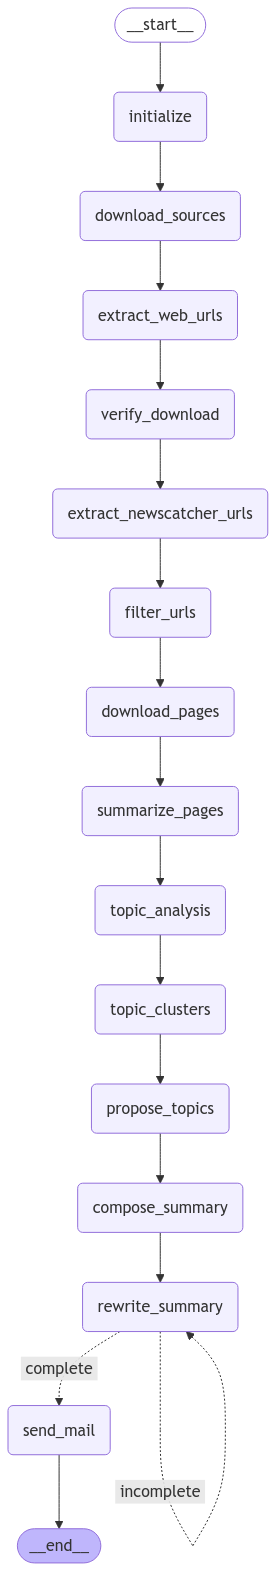

In [36]:
before_date = None
# before_date = '2025-02-15 18:00'
do_download = True

state, lg_agent, thread_id = initialize_agent(do_download, before_date)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [37]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


2025-02-17 11:02:26,756 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-02-17 11:02:26,757 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-02-17 11:02:26,757 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-02-17 11:02:26,758 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-02-17 11:02:26,758 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-02-17 11:02:26,759 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-02-17 11:02:26,759 - AInewsbot - INFO - 

AIdf:
'src'
AIdf:
'src'


FileNotFoundError: [Errno 2] No such file or directory: 'htmlpages'

In [38]:
# state["sources"]


In [ ]:
# it will stop here if check not passed
# or if we force a stop compiling with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-02-15 18:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
state = lg_agent.initialize(state)


In [ ]:
state = lg_agent.download_sources(state)


In [ ]:
state = lg_agent.extract_web_urls(state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
state = lg_agent.verify_download(state)


In [ ]:
state = lg_agent.extract_newscatcher_urls(state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
state = lg_agent.download_pages(state)


In [ ]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))

In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# series of structured AI prompts to ask if standard topics are covered 
state = lg_agent.topic_analysis(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].title_topic_str))

In [ ]:
state = lg_agent.topic_clusters(state)


In [ ]:
state = lg_agent.propose_topics(state)


In [ ]:
state


In [ ]:
# compose using o3-mini and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


In [ ]:
display(Markdown(state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


In [ ]:
SCREENSHOT_DIR


In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")


In [ ]:
!cat input.txt

In [ ]:
!ffmpeg -y -f concat -i input.txt -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -pix_fmt yuv420p podcast2.mp4

In [ ]:
# there is a way to get speech models to output timing data and generate srt captions automatically
# but because of the way podcastfy processes text in chunks it's kind of complicated

# def generate_speech_with_timings(text):
#     # Initialize the client
#     client = texttospeech.TextToSpeechClient()

#     # Configure the input
#     synthesis_input = texttospeech.SynthesisInput(text=text)

#     # Build the voice request
#     voice = texttospeech.VoiceSelectionParams(
#         language_code="en-US",
#         name="en-US-Standard-A"
#     )

#     # Configure audio settings
#     audio_config = texttospeech.AudioConfig(
#         audio_encoding=texttospeech.AudioEncoding.MP3,
#         enable_time_pointing=['SSML_MARK']  # Enable time markers
#     )

#     # Add SSML marks to the text
#     marked_text = ""
#     words = text.split()
#     for i, word in enumerate(words):
#         marked_text += f'<mark name="{i}"/>{word} '

#     # Wrap in SSML tags
#     ssml_text = f'<speak>{marked_text}</speak>'

#     # Set the input with SSML
#     synthesis_input = texttospeech.SynthesisInput(ssml=ssml_text)

#     # Perform the text-to-speech request
#     response = client.synthesize_speech(
#         input=synthesis_input,
#         voice=voice,
#         audio_config=audio_config
#     )

#     # Get the audio content
#     audio_content = response.audio_content

#     # Get the timepoints
#     timepoints = response.timepoints

#     return audio_content, timepoints

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
AIdf.to_csv("x.csv")


In [ ]:
AIdf=pd.DataFrame(state['AIdf'])
AIdf.loc[AIdf["url"].str.search("https://msn") > 0][['id', 'url']]




In [ ]:
AIdf.iloc[8].url

In [ ]:
AIdf.iloc[9].url

In [ ]:
AIdf.iloc[13].url == AIdf.iloc[9].url

In [ ]:
new_state = fn_filter_urls(state)


In [ ]:
AIdf2=pd.DataFrame(new_state['AIdf'])
AIdf2


In [ ]:
AIdf2.loc[AIdf2["title"].str.startswith("New AI tool")][['id', 'url', 'site_name']]
